本部分内容将利用深度学习方法来进行DGA的分类情况，同时对比多种方法的性能

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#加载必要的工作库" data-toc-modified-id="加载必要的工作库-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>加载必要的工作库</a></span></li><li><span><a href="#加载数据并转化为DataFrame" data-toc-modified-id="加载数据并转化为DataFrame-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>加载数据并转化为DataFrame</a></span></li><li><span><a href="#数据处理函数" data-toc-modified-id="数据处理函数-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据处理函数</a></span></li><li><span><a href="#LSTM实验" data-toc-modified-id="LSTM实验-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LSTM实验</a></span><ul class="toc-item"><li><span><a href="#实验：是否DGA的分类" data-toc-modified-id="实验：是否DGA的分类-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>实验：是否DGA的分类</a></span></li><li><span><a href="#实验：家族分类" data-toc-modified-id="实验：家族分类-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>实验：家族分类</a></span></li><li><span><a href="#部分数据分析（去掉数量较少内容）" data-toc-modified-id="部分数据分析（去掉数量较少内容）-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>部分数据分析（去掉数量较少内容）</a></span></li></ul></li><li><span><a href="#CNN实验" data-toc-modified-id="CNN实验-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CNN实验</a></span><ul class="toc-item"><li><span><a href="#是否dga分类" data-toc-modified-id="是否dga分类-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>是否dga分类</a></span></li><li><span><a href="#家族分类" data-toc-modified-id="家族分类-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>家族分类</a></span></li></ul></li><li><span><a href="#绘制相关曲线" data-toc-modified-id="绘制相关曲线-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>绘制相关曲线</a></span><ul class="toc-item"><li><span><a href="#绘制roc曲线" data-toc-modified-id="绘制roc曲线-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>绘制roc曲线</a></span></li><li><span><a href="#绘制家族分类混淆矩阵" data-toc-modified-id="绘制家族分类混淆矩阵-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>绘制家族分类混淆矩阵</a></span></li></ul></li></ul></div>

# 加载必要的工作库

In [140]:
#记载一些必要的库
import pandas as pd
import seaborn as sns
import numpy as np
import tldextract
import matplotlib
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report   
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [56]:
#加载深度学习库
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import CuDNNLSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import models
from keras.layers import Conv1D, Input, Dense, concatenate
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import Flatten

# 加载数据并转化为DataFrame

In [3]:
#360 data下载与 https://data.netlab.360.com/feeds/dga/dga.txt 20200807
malicious_dns_file = "./data/dga.txt"
#top-1m.csv.zip 下载与 downloaded from http://s3.amazonaws.com/alexa-static/top-1m.csv.zip 20200807
normal_dns_file = "./data/top-1m.csv.zip"

data_dir = "./data/"

#pandas可以直接加载zip文件
normal_dns_df = pd.read_csv(normal_dns_file, header = None, names = ['No','Name'] )
normal_dns_df.drop(['No'],axis = 1, inplace = True)

malicious_dns_data = []
with open(malicious_dns_file, "r") as f:
    for line in f:
        #过滤注释行
        if line.startswith("#"):
            continue
        tmp_line = line.strip("\n").split("\t")
        #过滤空行
        if len(tmp_line) == 1:
            continue
        #nymaim\tarfxsmjug.net\t2020-08-07 00:00:00\t2020-08-07 23:59:59
        malicious_dns_data.append(tmp_line[:2])

malicious_dns_df = pd.DataFrame(malicious_dns_data, columns=['Family','Name'])

normal_dns_df['Is_dga'] = 0
normal_dns_df['Family'] = "Normal"
malicious_dns_df['Is_dga'] = 1
all_dns_df = pd.concat([normal_dns_df, malicious_dns_df], sort=False)

In [4]:
def extract_domain_info(x):
    ext = tldextract.extract(x)
    subdomain, domain, suffix = ext.subdomain, ext.domain, ext.suffix
    return (subdomain, domain, suffix)

#从https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns 多列生成方法
all_dns_df['Subdomain'], all_dns_df[ 'Domain'], all_dns_df['Suffix']  = zip(*all_dns_df['Name'].map(extract_domain_info))

In [15]:
dns_data_df = all_dns_df[['Domain','Family', 'Is_dga']]

# 数据处理函数

In [6]:
def get_features_and_labels(X, y):
    valid_chars = {x : idx + 1 for idx, x in enumerate(set(''.join(X)))}
    max_features = len(valid_chars) + 1
    maxlen = max([len(x) for x in X])

    X = [[valid_chars[y] for y in x] for x in X]
    X = sequence.pad_sequences(X, maxlen = maxlen)
    
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    y = to_categorical(y)
    nb_class = y.shape[1]
    
    return X, y, nb_class, max_features, maxlen, le

# LSTM实验

In [7]:
def build_lstm_model(max_features, maxlen, nb_class):
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length = maxlen))
    model.add(CuDNNLSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(nb_class))
    model.add(Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [39]:
def run_lstm_model(features, label, batch_size = 128, epochs = 10):
    X, y, nb_class, max_features, maxlen, le = get_features_and_labels(features, label)
    lstm_model = build_lstm_model(max_features, maxlen, nb_class)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print("Trainning...")
    lstm_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)
    print("Predictting...")
    y_pred = lstm_model.predict_classes(X_test, verbose = 1)
    print("Report:")
    y_test = np.argmax(y_test, axis = 1)
    print(classification_report(y_test, y_pred,labels = [ i for i in range(nb_class)], target_names = le.classes_))

## 实验：是否DGA的分类

In [9]:
features = dns_data_df.Domain.values
label = dns_data_df.Is_dga.map(lambda x: str(x)).values

run_lstm_model(features, label, 128, 10)

Trainning...
Epoch 1/10
1350137/1350137 [==============================] - 96s 71us/step - loss: 0.0766 - acc: 0.9730
Epoch 2/10
1350137/1350137 [==============================] - 87s 65us/step - loss: 0.0382 - acc: 0.9875
Epoch 3/10
1350137/1350137 [==============================] - 87s 64us/step - loss: 0.0316 - acc: 0.9896
Epoch 4/10
1350137/1350137 [==============================] - 88s 65us/step - loss: 0.0282 - acc: 0.9905
Epoch 5/10
1350137/1350137 [==============================] - 90s 66us/step - loss: 0.0258 - acc: 0.9914
Epoch 6/10
1350137/1350137 [==============================] - 90s 67us/step - loss: 0.0237 - acc: 0.9920
Epoch 7/10
1350137/1350137 [==============================] - 88s 65us/step - loss: 0.0224 - acc: 0.9923
Epoch 8/10
1350137/1350137 [==============================] - 88s 65us/step - loss: 0.0212 - acc: 0.9927
Epoch 9/10
1350137/1350137 [==============================] - 90s 67us/step - loss: 0.0204 - acc: 0.9929
Epoch 10/10
1350137/1350137 [=============

## 实验：家族分类

In [40]:
features = dns_data_df[dns_data_df.Family != 'Normal'].Domain.values
family_label = dns_data_df[dns_data_df.Family != 'Normal'].Family.values

run_lstm_model(features, family_label, 128, 10)

Trainning...
Epoch 1/10
876751/876751 [==============================] - 49s 56us/step - loss: 0.3260 - acc: 0.9060
Epoch 2/10
876751/876751 [==============================] - 47s 53us/step - loss: 0.1208 - acc: 0.9704
Epoch 3/10
876751/876751 [==============================] - 49s 55us/step - loss: 0.1022 - acc: 0.9747
Epoch 4/10
876751/876751 [==============================] - 48s 55us/step - loss: 0.0948 - acc: 0.9763
Epoch 5/10
876751/876751 [==============================] - 49s 56us/step - loss: 0.0930 - acc: 0.9768
Epoch 6/10
876751/876751 [==============================] - 48s 55us/step - loss: 0.0880 - acc: 0.9779
Epoch 7/10
876751/876751 [==============================] - 49s 56us/step - loss: 0.0861 - acc: 0.9782
Epoch 8/10
876751/876751 [==============================] - 48s 55us/step - loss: 0.0852 - acc: 0.9784
Epoch 9/10
876751/876751 [==============================] - 48s 55us/step - loss: 0.0838 - acc: 0.9787
Epoch 10/10
876751/876751 [==============================] -

## 部分数据分析（去掉数量较少内容）

In [41]:
family_filtered = dns_data_df[dns_data_df.Family != 'Normal'].Family.value_counts()
used_family = family_filtered[family_filtered >= 1000].index.tolist()

features = dns_data_df[dns_data_df.Family.isin(used_family)].Domain.values
family_label = dns_data_df[dns_data_df.Family.isin(used_family)].Family.values

run_lstm_model(features, family_label, 128, 10)

Trainning...
Epoch 1/10
871564/871564 [==============================] - 49s 57us/step - loss: 0.2492 - acc: 0.9259
Epoch 2/10
871564/871564 [==============================] - 48s 55us/step - loss: 0.0868 - acc: 0.9772
Epoch 3/10
871564/871564 [==============================] - 49s 56us/step - loss: 0.0757 - acc: 0.9801
Epoch 4/10
871564/871564 [==============================] - 48s 55us/step - loss: 0.0707 - acc: 0.9815
Epoch 5/10
871564/871564 [==============================] - 48s 56us/step - loss: 0.0679 - acc: 0.9822
Epoch 6/10
871564/871564 [==============================] - 48s 55us/step - loss: 0.0666 - acc: 0.9826
Epoch 7/10
871564/871564 [==============================] - 48s 56us/step - loss: 0.0653 - acc: 0.9828
Epoch 8/10
871564/871564 [==============================] - 48s 55us/step - loss: 0.0645 - acc: 0.9829
Epoch 9/10
871564/871564 [==============================] - 48s 55us/step - loss: 0.0638 - acc: 0.9831
Epoch 10/10
871564/871564 [==============================] -

# CNN实验

In [57]:
def build_cnn_model(max_features, maxlen, nb_class):
    
    text_input = Input(shape = (maxlen,))
    x = Embedding(output_dim = 128, 
            input_dim= max_features, 
            input_length=maxlen)(text_input)

    conv_a = Conv1D(15,2, activation='relu')(x)
    conv_b = Conv1D(15,4, activation='relu')(x)
    conv_c = Conv1D(15,6, activation='relu')(x)

    pool_a = GlobalMaxPooling1D()(conv_a)
    pool_b = GlobalMaxPooling1D()(conv_b)
    pool_c = GlobalMaxPooling1D()(conv_c)

    flattened = concatenate([pool_a, pool_b, pool_c])

    drop = Dropout(.2)(flattened)
 
    dense = Dense(nb_class)(drop)
    out = Activation("sigmoid")(dense)

    model = models.Model(inputs=text_input, outputs=out)

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model

In [58]:
def my_cnn_model(max_features, maxlen, nb_class):
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Conv1D(15,2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(nb_class))
    model.add(Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [74]:
def run_cnn_model(features, label, batch_size = 128, epochs = 10):
    X, y, nb_class, max_features, maxlen, le = get_features_and_labels(features, label)
    cnn_model = build_cnn_model(max_features, maxlen, nb_class)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print("Trainning...")
    cnn_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)
    print("Predictting...")
    y_pred = cnn_model.predict(X_test, verbose = 1)
    print("Report:") 
    y_pred = np.argmax(y_pred, axis = 1)
    y_test = np.argmax(y_test, axis = 1)
    print(classification_report(y_test, y_pred, labels = [ i for i in range(nb_class)], target_names = le.classes_))

## 是否dga分类

In [76]:
features = dns_data_df.Domain.values
label = dns_data_df.Is_dga.map(lambda x: str(x)).values
run_cnn_model(features, label,  batch_size = 128, epochs = 10)

Trainning...
Epoch 1/10
1350137/1350137 [==============================] - 71s 52us/step - loss: 0.0943 - acc: 0.9671
Epoch 2/10
1350137/1350137 [==============================] - 68s 50us/step - loss: 0.0726 - acc: 0.9754
Epoch 3/10
1350137/1350137 [==============================] - 71s 53us/step - loss: 0.0687 - acc: 0.9767
Epoch 4/10
1350137/1350137 [==============================] - 71s 53us/step - loss: 0.0666 - acc: 0.9773
Epoch 5/10
1350137/1350137 [==============================] - 69s 51us/step - loss: 0.0651 - acc: 0.9780
Epoch 6/10
1350137/1350137 [==============================] - 73s 54us/step - loss: 0.0646 - acc: 0.9782
Epoch 7/10
1350137/1350137 [==============================] - 71s 53us/step - loss: 0.0635 - acc: 0.9786
Epoch 8/10
1350137/1350137 [==============================] - 67s 50us/step - loss: 0.0630 - acc: 0.9788
Epoch 9/10
1350137/1350137 [==============================] - 69s 51us/step - loss: 0.0626 - acc: 0.9789
Epoch 10/10
1350137/1350137 [=============

## 家族分类

In [77]:
family_filtered = dns_data_df[dns_data_df.Family != 'Normal'].Family.value_counts()
used_family = family_filtered[family_filtered >= 1000].index.tolist()

features = dns_data_df[dns_data_df.Family.isin(used_family)].Domain.values
family_label = dns_data_df[dns_data_df.Family.isin(used_family)].Family.values

run_cnn_model(features, family_label)

Trainning...
Epoch 1/10
871564/871564 [==============================] - 47s 54us/step - loss: 0.4607 - acc: 0.8691
Epoch 2/10
871564/871564 [==============================] - 44s 51us/step - loss: 0.3403 - acc: 0.9059
Epoch 3/10
871564/871564 [==============================] - 43s 50us/step - loss: 0.3269 - acc: 0.9103
Epoch 4/10
871564/871564 [==============================] - 42s 49us/step - loss: 0.3196 - acc: 0.9133
Epoch 5/10
871564/871564 [==============================] - 44s 51us/step - loss: 0.3155 - acc: 0.9146
Epoch 6/10
871564/871564 [==============================] - 44s 50us/step - loss: 0.3122 - acc: 0.9157
Epoch 7/10
871564/871564 [==============================] - 43s 49us/step - loss: 0.3103 - acc: 0.9163
Epoch 8/10
871564/871564 [==============================] - 43s 50us/step - loss: 0.3086 - acc: 0.9172
Epoch 9/10
871564/871564 [==============================] - 42s 48us/step - loss: 0.3065 - acc: 0.9176
Epoch 10/10
871564/871564 [==============================] -

/home/inet703/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     banjori       1.00      1.00      1.00    149473
      chinad       0.94      0.15      0.26       305
cryptolocker       0.00      0.00      0.00       343
        dyre       1.00      0.90      0.95       314
      emotet       0.87      0.99      0.92    133691
    gameover       0.93      0.71      0.80      3853
       locky       0.00      0.00      0.00       383
     murofet       0.85      0.34      0.49      2849
      necurs       0.00      0.00      0.00      2709
   pykspa_v1       0.94      0.98      0.96     14885
      qadars       0.97      0.95      0.96       653
      ramnit       0.50      0.00      0.00      6545
     ranbyus       0.00      0.00      0.00      3615
      rovnix       0.96      0.99      0.98     59235
       shifu       0.75      0.00      0.01       834
     shiotob       0.97      0.46      0.63      2674
       simda       0.99      1.00      0.99      8279
    suppobox       0.81    

# 绘制相关曲线

## 绘制roc曲线

In [168]:
def roc_lstm_model(max_features, maxlen):
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length = maxlen))
    model.add(CuDNNLSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model
    
def roc_cnn_model(max_features, maxlen):
    
    text_input = Input(shape = (maxlen,))
    x = Embedding(output_dim = 128, 
            input_dim= max_features, 
            input_length=maxlen)(text_input)

    conv_a = Conv1D(15,2, activation='relu')(x)
    conv_b = Conv1D(15,4, activation='relu')(x)
    conv_c = Conv1D(15,6, activation='relu')(x)

    pool_a = GlobalMaxPooling1D()(conv_a)
    pool_b = GlobalMaxPooling1D()(conv_b)
    pool_c = GlobalMaxPooling1D()(conv_c)

    flattened = concatenate([pool_a, pool_b, pool_c])

    drop = Dropout(.2)(flattened)
 
    dense = Dense(1)(drop)
    out = Activation("sigmoid")(dense)

    model = models.Model(inputs=text_input, outputs=out)

    model.compile(loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model

def run_both_model(features, label, batch_size = 128, epochs = 10):
    X, y, nb_class, max_features, maxlen, _ = get_features_and_labels(features, label)
    y = np.argmax(y, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    cnn_model = roc_cnn_model(max_features, maxlen)
    lstm_model = roc_lstm_model(max_features, maxlen)
    
    cnn_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)
    lstm_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)
    lstm_y_prob = lstm_model.predict_proba(X_test, verbose = 1)
    cnn_y_prob = cnn_model.predict(X_test, verbose = 1)
    
    
    lstm_y_pred = lstm_model.predict_classes(X_test, verbose = 1)
    
    cnn_y_pred = cnn_model.predict(X_test, verbose = 1)
    cnn_y_pred = np.round(cnn_y_pred)
    
    
    lstm_auc = roc_auc_score(y_test, lstm_y_prob)
    cnn_auc =  roc_auc_score(y_test, cnn_y_prob)
    print("The auc score of lstm is %f" % lstm_auc)
    print("The auc score of cnn is %f" % cnn_auc)
    print("The classification report of lstm:")
    print(classification_report(y_test,lstm_y_pred,digits=4))
    print("-----")
    print("The classification report of cnn:")
    print(classification_report(y_test, cnn_y_pred, digits=4))
    print("-----")
    
    lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_y_prob)
    cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_y_prob)
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize= (12,10))
    plt.plot(lstm_fpr, lstm_tpr, linewidth = '1', label='LSTM')
    plt.plot(cnn_fpr, cnn_tpr, linewidth = '1', label='CNN')
    plt.xlabel('False Positive Rate', fontsize=22)
    plt.ylabel('True Positive Rate', fontsize=22)
    plt.title('ROC - Binary Classification', fontsize=26)
    plt.legend(loc="lower right", fontsize=22)
    plt.tick_params(axis='both', labelsize=22)

Epoch 1/10
1350137/1350137 [==============================] - 37s 27us/step - loss: 0.1135 - acc: 0.9588
Epoch 2/10
1350137/1350137 [==============================] - 28s 21us/step - loss: 0.0762 - acc: 0.9742
Epoch 3/10
1350137/1350137 [==============================] - 29s 21us/step - loss: 0.0716 - acc: 0.9759
Epoch 4/10
1350137/1350137 [==============================] - 29s 21us/step - loss: 0.0695 - acc: 0.9765
Epoch 5/10
1350137/1350137 [==============================] - 29s 21us/step - loss: 0.0680 - acc: 0.9771
Epoch 6/10
1350137/1350137 [==============================] - 30s 22us/step - loss: 0.0671 - acc: 0.9773
Epoch 7/10
1350137/1350137 [==============================] - 29s 22us/step - loss: 0.0662 - acc: 0.9776
Epoch 8/10
1350137/1350137 [==============================] - 28s 21us/step - loss: 0.0656 - acc: 0.9779
Epoch 9/10
1350137/1350137 [==============================] - 28s 21us/step - loss: 0.0654 - acc: 0.9781
Epoch 10/10
1350137/1350137 [==========================

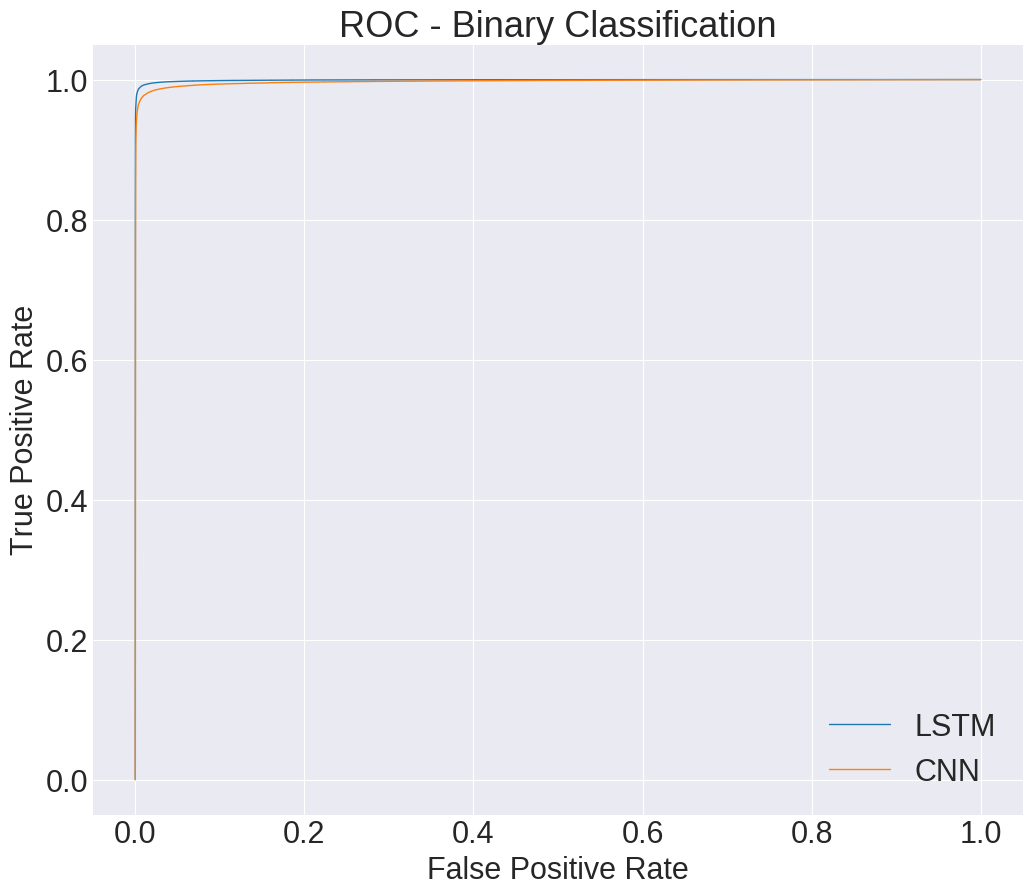

In [169]:
features = dns_data_df.Domain.values
label = dns_data_df.Is_dga.values
run_both_model(features, label, batch_size = 512, epochs = 10)

## 绘制家族分类混淆矩阵

In [135]:
#本部分代码来自： https://mathpretty.com/10675.html
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig = plt.figure(figsize = (20,16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                fontsize = 20)
    
    
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label',fontsize=22)
    plt.title(title, fontsize = 26)
    plt.tight_layout()
    plt.show()

Epoch 1/15
868778/868778 [==============================] - 64s 73us/step - loss: 0.2165 - acc: 0.9342
Epoch 2/15
868778/868778 [==============================] - 56s 64us/step - loss: 0.0777 - acc: 0.9790
Epoch 3/15
868778/868778 [==============================] - 58s 66us/step - loss: 0.0658 - acc: 0.9822
Epoch 4/15
868778/868778 [==============================] - 57s 66us/step - loss: 0.0616 - acc: 0.9834
Epoch 5/15
868778/868778 [==============================] - 55s 63us/step - loss: 0.0593 - acc: 0.9840
Epoch 6/15
868778/868778 [==============================] - 56s 64us/step - loss: 0.0572 - acc: 0.9844
Epoch 7/15
868778/868778 [==============================] - 58s 67us/step - loss: 0.0562 - acc: 0.9847
Epoch 8/15
868778/868778 [==============================] - 55s 63us/step - loss: 0.0556 - acc: 0.9848
Epoch 9/15
868778/868778 [==============================] - 57s 66us/step - loss: 0.0548 - acc: 0.9850
Epoch 10/15
868778/868778 [==============================] - 55s 64us/ste

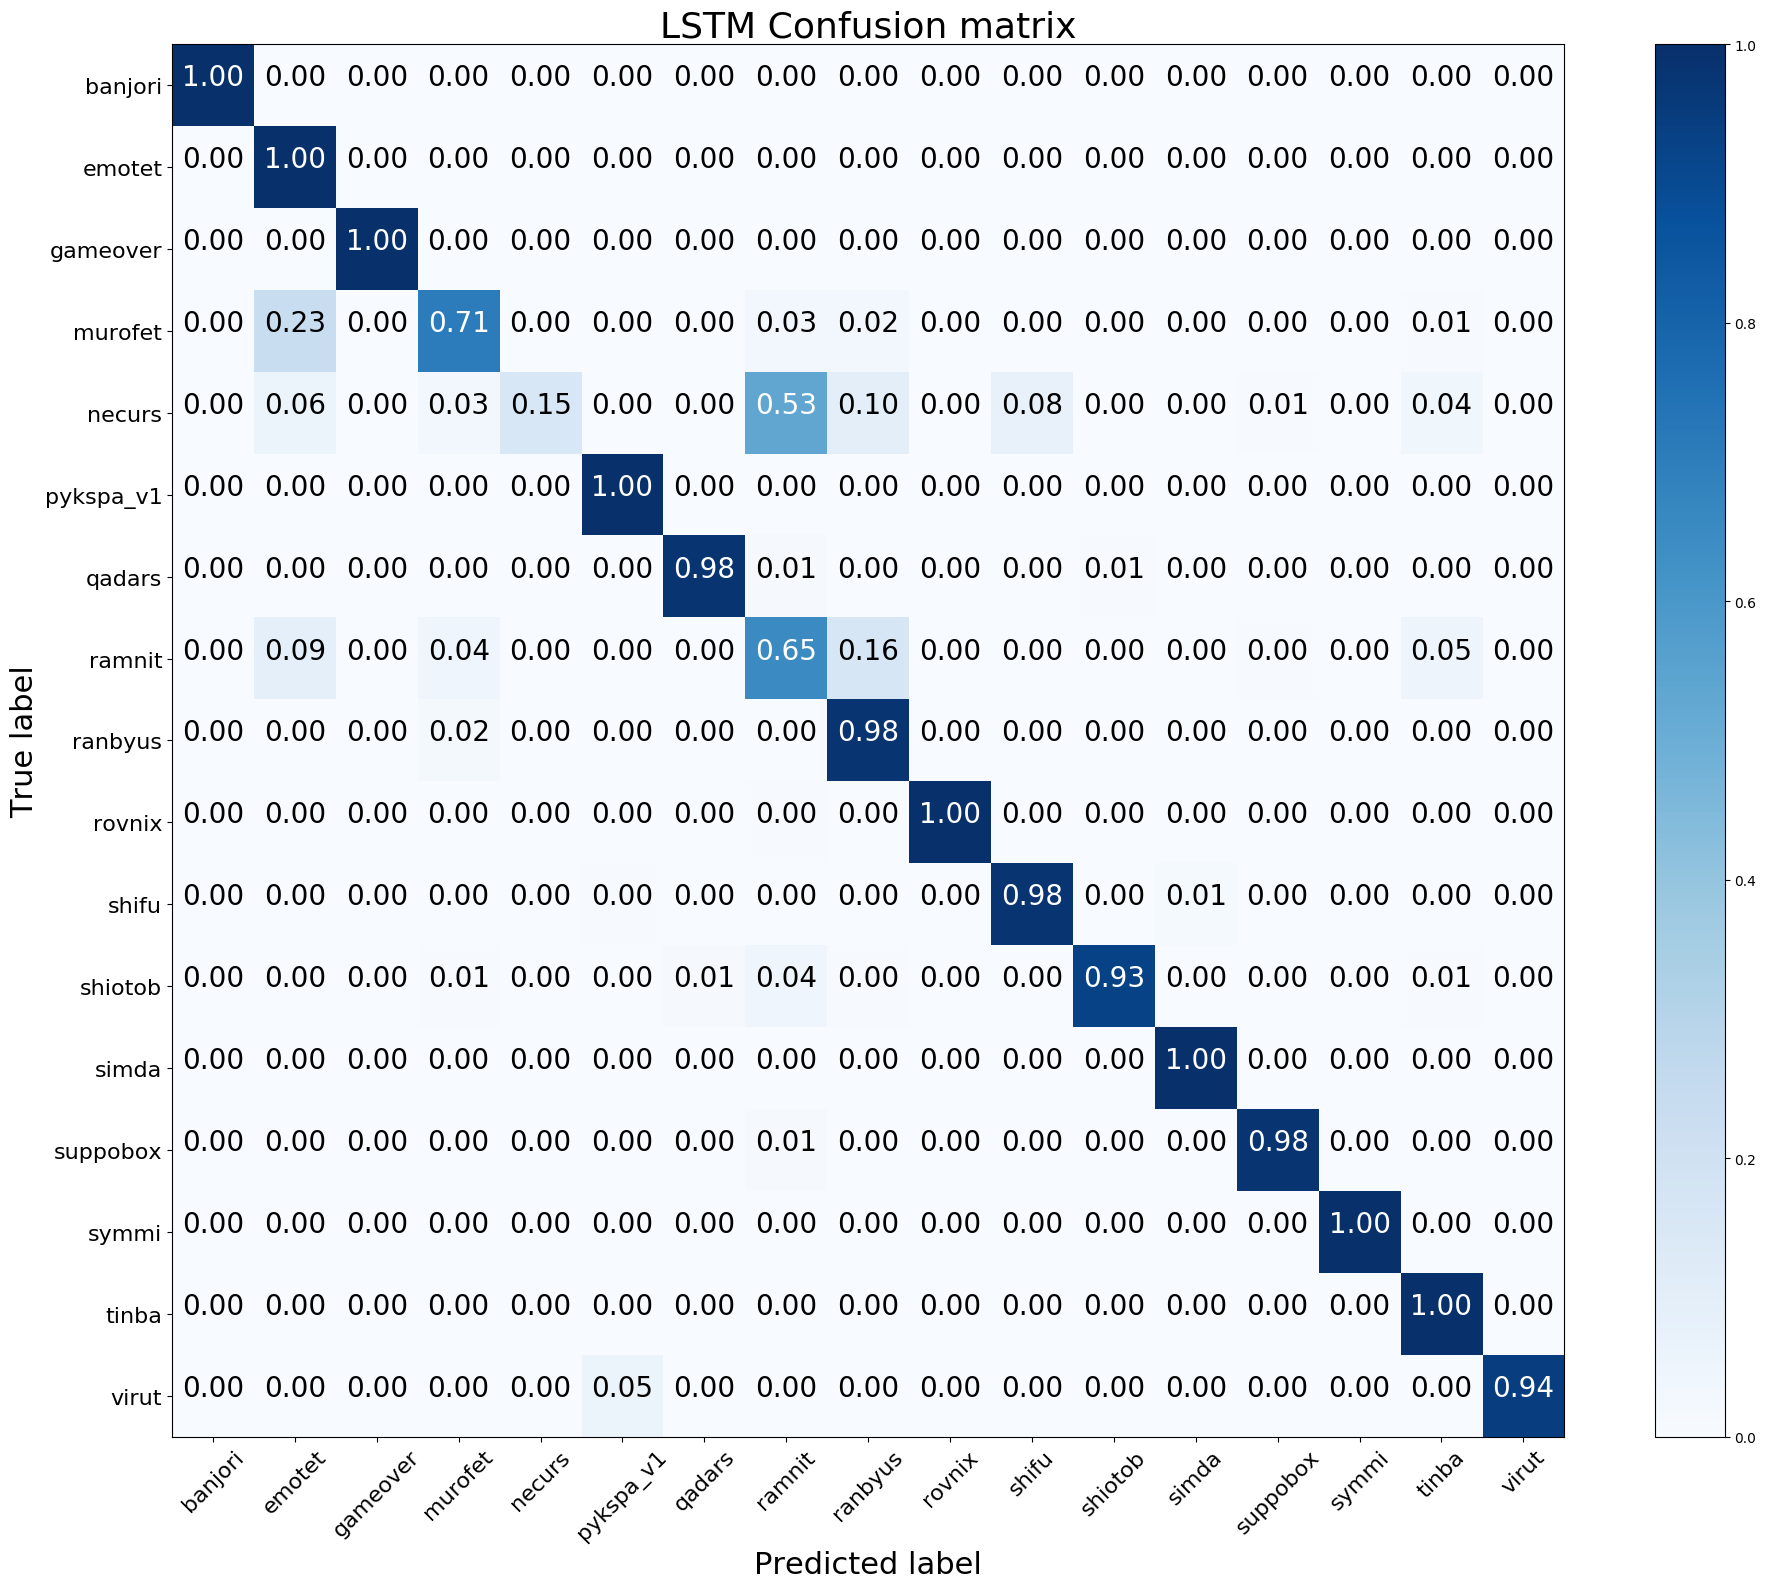

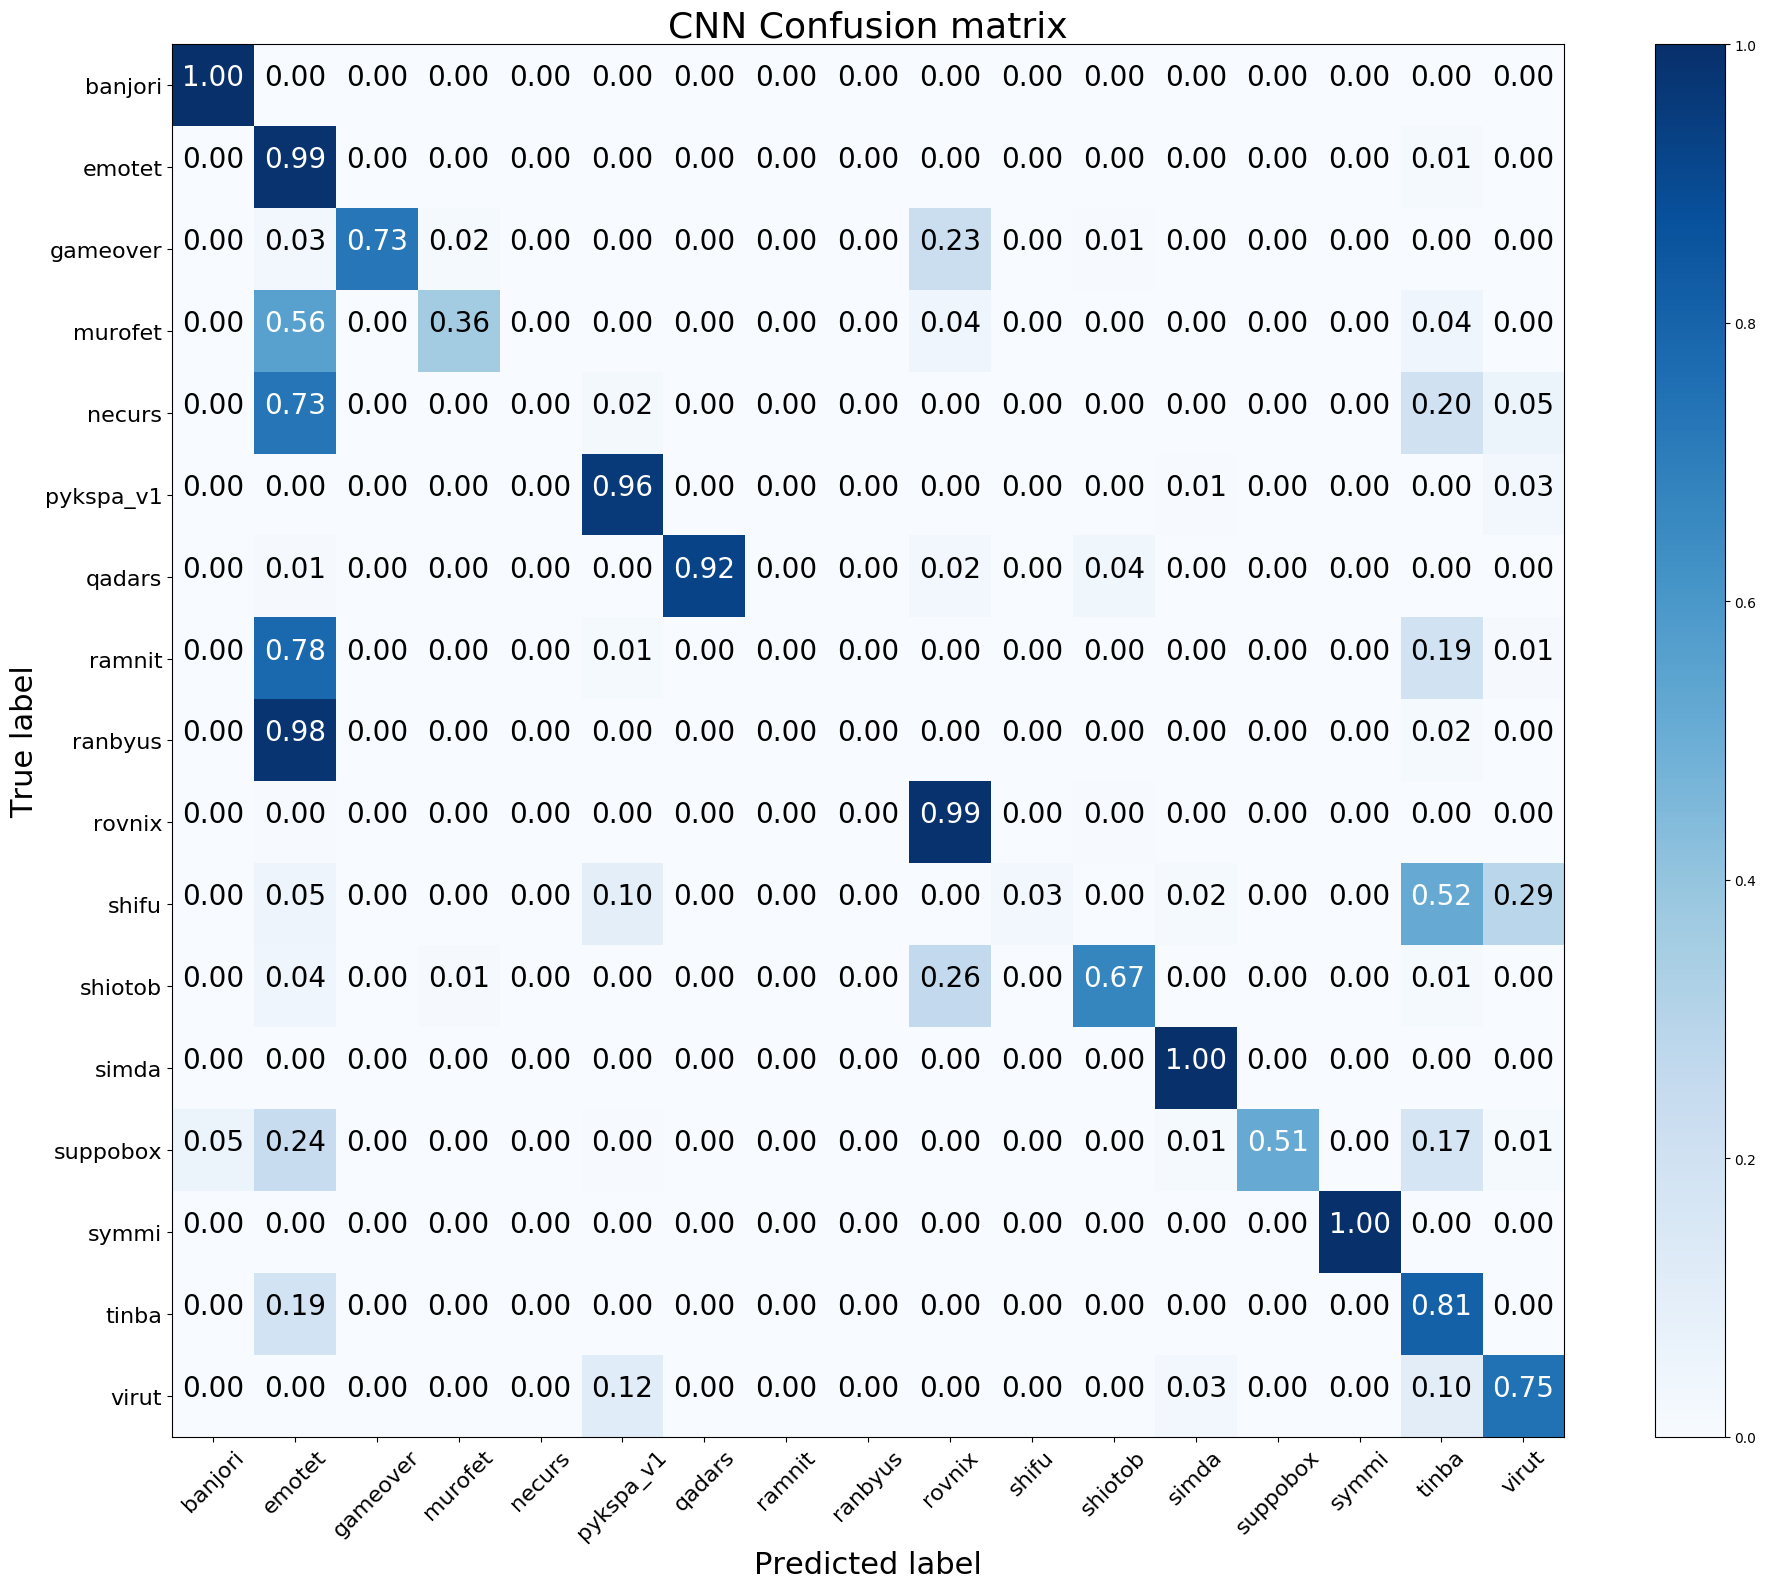

In [155]:
family_filtered = dns_data_df[dns_data_df.Family != 'Normal'].Family.value_counts()
used_family = family_filtered[family_filtered >= 2000].index.tolist()

features = dns_data_df[dns_data_df.Family.isin(used_family)].Domain.values
family_label = dns_data_df[dns_data_df.Family.isin(used_family)].Family.values
        
def run_both_family_model(features, label, batch_size = 128, epochs = 10):
    X, y, nb_class, max_features, maxlen, le = get_features_and_labels(features, label)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    lstm_model = build_lstm_model(max_features, maxlen, nb_class)
    lstm_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)
    
    cnn_model = build_cnn_model(max_features, maxlen, nb_class)
    cnn_model.fit(X_train, y_train,  batch_size = batch_size, epochs = epochs)

    
    lstm_y_pred = lstm_model.predict_classes(X_test, verbose = 1)
    cnn_y_pred = cnn_model.predict(X_test, verbose = 1)
    
    
    y_test = np.argmax(y_test, axis = 1)
    cnn_y_pred = np.argmax(cnn_y_pred, axis = 1)
    
    
    lstm_conf_matrix = confusion_matrix(y_test, lstm_y_pred)
    cnn_conf_matrix = confusion_matrix(y_test, cnn_y_pred)
    
    
    plot_confusion_matrix(lstm_conf_matrix, le.classes_, normalize = True, title='LSTM Confusion matrix')
    plot_confusion_matrix(cnn_conf_matrix, le.classes_, normalize = True, title='CNN Confusion matrix')
    
matplotlib.rcdefaults()
run_both_family_model(features, family_label, batch_size = 128, epochs = 15)